# 1. prepair training set

In [1]:
# usd BFS search, return all corpus files as a list of string
import os
def get_corpus(corpus_path):
#     corpus_path = '../week_2/wiki_corpus/wiki_chs'
    corpus_list = []
    need_visit = [corpus_path]
    while need_visit:
        path = need_visit.pop(0)
        if os.path.isdir(path):
            need_visit += [path + '/' + p for p in os.listdir(path)]
        elif '.DS_Store' not in path:
            corpus_list.append(path)
    return corpus_list

# save the results on distk
import pickle

def save_obj(obj, file_name):
    pickle.dump(obj, open(file_name, 'wb'))
    
def load_obj(file_name):
    obj = pickle.load(open(file_name, 'rb'))
    return obj

corpus_list = get_corpus('../week_2/wiki_corpus/wiki_chs') 
print('first 10:', corpus_list[:10])
print('\ntotal corpus:', len(corpus_list))

first 10: ['../week_2/wiki_corpus/wiki_chs/AE/wiki_52', '../week_2/wiki_corpus/wiki_chs/AE/wiki_66', '../week_2/wiki_corpus/wiki_chs/AE/wiki_36', '../week_2/wiki_corpus/wiki_chs/AE/wiki_75', '../week_2/wiki_corpus/wiki_chs/AE/wiki_90', '../week_2/wiki_corpus/wiki_chs/AE/wiki_06', '../week_2/wiki_corpus/wiki_chs/AE/wiki_95', '../week_2/wiki_corpus/wiki_chs/AE/wiki_85', '../week_2/wiki_corpus/wiki_chs/AE/wiki_07', '../week_2/wiki_corpus/wiki_chs/AE/wiki_20']

total corpus: 1230


## 1.1 preprocessing

In [2]:
import re
import jieba
from functools import reduce

def replace_nums(string):
    return re.sub('\d+','<num>', string)

def process_sent(sent:list):
    return [replace_nums(w) for w in sent]
    
def tokenize_string(string):
    string = ' '.join(re.findall('.+',string))
    docs = [doc.split('。') for doc in re.findall('<doc.+?">(.+?)</doc>',string)]
    
    sents = [process_sent(jieba.cut(sent.strip()))+['。'] for sent in reduce(lambda a,b:a+b, docs) if sent != ' ']
    return sents

def get_training_data(input_file):
    with open(input_file, 'r') as f:
        tokens = tokenize_string(f.read())
        return tokens

get_training_data

<function __main__.get_training_data(input_file)>

## 1.2 multi-process

In [3]:
#Multicore map reduce
import time
import multiprocessing
from tqdm import tqdm
import logging
jieba.setLogLevel(logging.WARNING)

def multiprocess(batch_file, target_func):
    pool = multiprocessing.Pool()
    result = pool.map(target_func, batch_file)
    pool.close()
    pool.join()
    result = reduce(lambda x, y : x + y, result)
    return result

def save_training_set(input_files:list, output_file:str, batch_size=64):
    def cut_list(lst, size): 
        return [lst[x:x+size] for x in range(0, len(lst), size)]
    
    counter = 0
    for batch in tqdm(cut_list(input_files, batch_size)):
        result = multiprocess(batch, get_training_data)
        counter += 1 
        save_obj(result, output_file+str(counter))

## 1.3 calculate and save data at the first time

In [4]:
!mkdir data
save_training_set(corpus_list, 'data/training_set')

mkdir: cannot create directory ‘data’: File exists


100%|██████████| 20/20 [11:31<00:00, 34.56s/it]


In [5]:
def demo_traning_set(n):
    traning_set = load_obj('data/training_set1')
    print(traning_set[:n])
    
demo_traning_set(10)

[['安济桥', ' ', '(', '衡水', ')', ' ', '衡水', '安济桥', '，', '又名', '衡水', '石桥', '或', '衡水', '老桥', '，', '座落在', '河北省', '衡水市', '滏阳', '河', '上', '，', '建成', '于', '乾隆', '三十一年', '（', '<num>', '年', '）', '。'], ['据', '《', '衡水', '县志', '》', '载', '：', '明朝', '天顺', '元年', '（', '<num>', '年', '）', '，', '衡水', '知县', '杨', '俨', '奏请', '上级', '批准', '修建', '一座', '木桥', '。'], ['后', '木桥', '因', '多次', '发大水', '屡修', '屡毁', '。'], ['至', '嘉靖', '三十二年', '（', '<num>', '年', '）', '，', '由', '衡水', '县', '徐廷', '募资', '修建', '石桥', '，', '隆庆', '三年', '（', '<num>', '年', '）', '复', '被', '大水', '冲毁', '，', '后', '由', '贾', '从仁', '募资', '修复', '。'], ['至', '清朝', '顺治', '五年', '（', '<num>', '年', '）', '由于', '滹沱河', '河床', '南徙', '并', '与', '滏阳', '河', '汇合', '，', '河水', '猛涨', '导致', '桥', '几乎', '被', '冲毁', '。'], ['清朝', '乾隆年间', '直隶', '总督', '方观', '承', '奏请', '朝廷', '批准', '，', '拨', '出', '银子', '四万七千', '六百多', '两', '修建', '石桥', '。'], ['派清', '河道', '周元理', '、', '通永道', '玉神保', '董理', '，', '同时', '知县', '陶淑', '亲自', '指挥', '。'], ['乾隆', '三十年', '（', '<num>', '年', '）', '正式', '动工', '，', '到', '翌年',

# 2. word2vec train online training
reference: https://rutumulkar.com/blog/2015/word2vec

In [6]:
from gensim.models import Word2Vec
from tqdm import tqdm

def save_model(file_name):
    corpus_list = get_corpus('data')
    print(corpus_list)
    model = Word2Vec(load_obj(corpus_list.pop()), min_count=3, workers=4)

    for training_data in tqdm(corpus_list):
        training_data = load_obj(training_data)
        model.build_vocab(training_data, update=True)
        model.train(training_data , total_examples=model.corpus_count, epochs=model.epochs)

    model.save(file_name)

## 2.1 save model at the first time

In [7]:
!mkdir model
save_model('model/word2vec.model')

mkdir: cannot create directory ‘model’: File exists
['data/training_set11', 'data/training_set20', 'data/training_set7', 'data/training_set6', 'data/training_set1', 'data/training_set15', 'data/training_set2', 'data/training_set3', 'data/training_set13', 'data/training_set8', 'data/training_set5', 'data/training_set16', 'data/training_set14', 'data/training_set4', 'data/training_set18', 'data/training_set12', 'data/training_set9', 'data/training_set19', 'data/training_set17', 'data/training_set10']


100%|██████████| 19/19 [13:46<00:00, 43.49s/it]


## 2.2 demo

In [8]:
from gensim.models import Word2Vec
from tqdm import tqdm

model = Word2Vec.load('model/word2vec.model')
print('number of vocab:', len(model.wv.vocab))

number of vocab: 603446


In [9]:
model.wv.similar_by_word('<num>%')

/home/bluan/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('％', 0.805665910243988),
 ('<num>.<num>%', 0.7832260131835938),
 ('一半', 0.7765429019927979),
 ('三分之一', 0.76158607006073),
 ('七成', 0.741263747215271),
 ('百分之五十', 0.7378852963447571),
 ('百分之十', 0.7326407432556152),
 ('百分之', 0.7317817211151123),
 ('八成', 0.7313559651374817),
 ('五分之一', 0.7257181406021118)]

In [10]:
model.wv.similar_by_word('数学')

[('数学分析', 0.8159098625183105),
 ('数理逻辑', 0.8001371026039124),
 ('概率论', 0.7891126871109009),
 ('微积分', 0.7867458462715149),
 ('统计学', 0.7806194424629211),
 ('语言学', 0.7804602384567261),
 ('逻辑学', 0.7674697637557983),
 ('计算机科学', 0.7547346949577332),
 ('数论', 0.7532446384429932),
 ('拓扑学', 0.7511755228042603)]

In [11]:
model.wv.similar_by_word('中国')

[('中华人民共和国', 0.6636042594909668),
 ('中华民国', 0.5597918033599854),
 ('雷翁国', 0.5576622486114502),
 ('我国', 0.5530818700790405),
 ('斗罗', 0.5367746353149414),
 ('景德镇', 0.5174817442893982),
 ('爱斯嘉', 0.5119806528091431),
 ('台湾', 0.5086368322372437),
 ('华北地区', 0.5040211081504822),
 ('东亚', 0.502571702003479)]

# 3. PCA visualization
reference:  https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import subprocess, numpy

def pca_plot(model, word_list:list):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in word_list:
        tokens.append(model[word])
        labels.append(word)
    
    training_data = [model.wv[w] for w in numpy.random.choice(list(model.wv.vocab.keys()),100000)]
    training_data = [model.wv[w] for w in model.wv.vocab.keys()]
    pca = PCA(n_components=2)
#     pca.fit(training_data)
    pca.fit(tokens)
    
    new_values = pca.transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

## 3.1 chinese front

In [18]:
from matplotlib.font_manager import FontManager

fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)

output = subprocess.check_output(
    'fc-list :lang=zh -f "%{family}\n"', shell=True)
output = output.decode('utf-8')
# print '*' * 10, '系统可用的中文字体', '*' * 10
# print output
zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
available = mat_fonts & zh_fonts

print('*' * 10, '可用的字体', '*' * 10)
for f in available:
    print(f)
    
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体，但在下运行的时候报了warning并没正常显示中文

********** 可用的字体 **********
Droid Sans Fallback
FangSong
Yahei Mono
YouYuan
Microsoft YaHei
YaHei Consolas Hybrid
KaiTi
LiSu
SimHei


## 3.2 visulization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


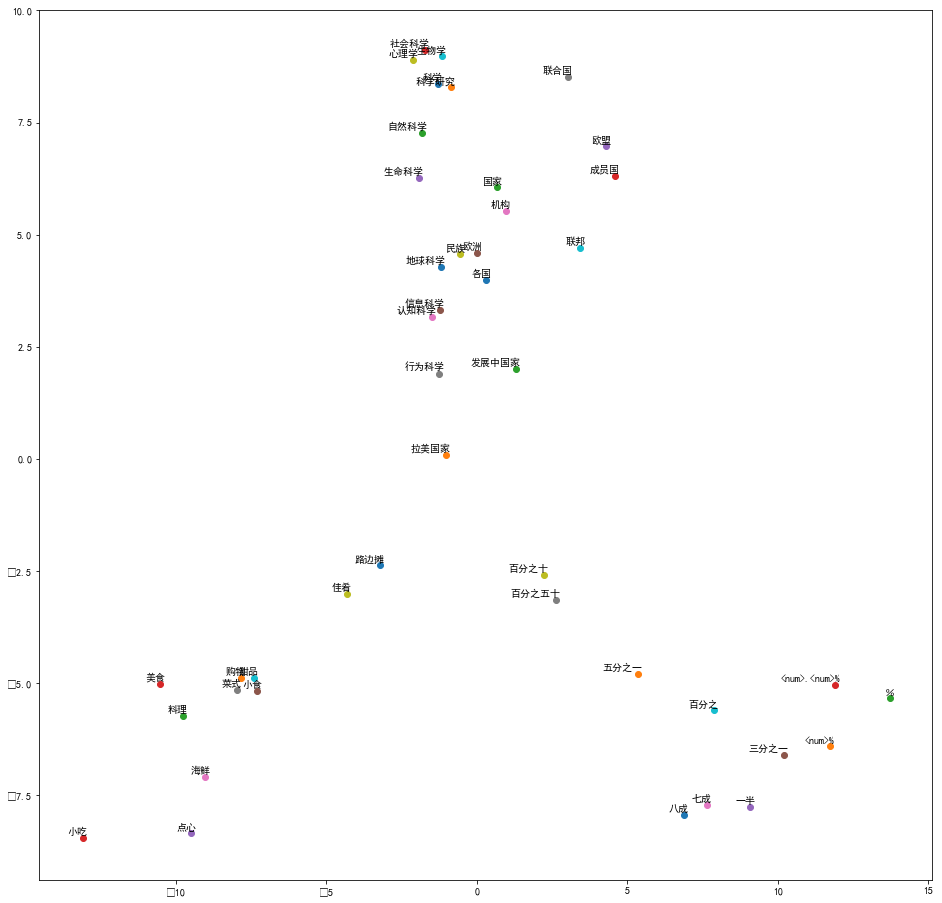

In [19]:
# visulization four topics:
word_list  = ['科学'] + [e[0] for e in model.wv.similar_by_word('科学')] 
word_list += ['<num>%'] + [e[0] for e in model.wv.similar_by_word('<num>%')]
word_list += ['国家'] + [e[0] for e in model.wv.similar_by_word('国家')]
word_list += ['美食'] + [e[0] for e in model.wv.similar_by_word('美食')]
        
pca_plot(model, word_list)